### *Enviroment Variables
All packages required to run this notebook can be found in environment.yml (anaconda environment)

# Dataset prepareation
First the dataset needs to be loaded and modified to only include the labels we want. This is done by merging unchosen labels to their closest related label. Cases where text has multiple labels for one entry are handled by choosing the label which has the lowest representation in the dataset so far.

In [11]:
from data.dataset import EmotionsDataset

train_dataset = EmotionsDataset(split="train")
valid_dataset = EmotionsDataset(split="valid")
test_dataset = EmotionsDataset(split="test")


No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


## Dataset Analysis
The training dataset has 43,410 entries while the testing dataset has 5,427 entries. The label distributions shows the data is vastly skewed towards the neural label (with other 12,000 entries) and also has a disproportionate amount of admiration labels (around 6,000). On the other hand the remorse and suprise labels are greatly under-represented with only a few hundred entries each. The remaining labels have a fair distribution between 1,000 and 3,000 entries each.  

In [12]:
print(train_dataset[0])
print("Training Length:", len(train_dataset))
print("Testing Length: ", len(test_dataset))

("My favourite food is anything I didn't have to cook myself.", 13)
Training Length: 43410
Testing Length:  5427


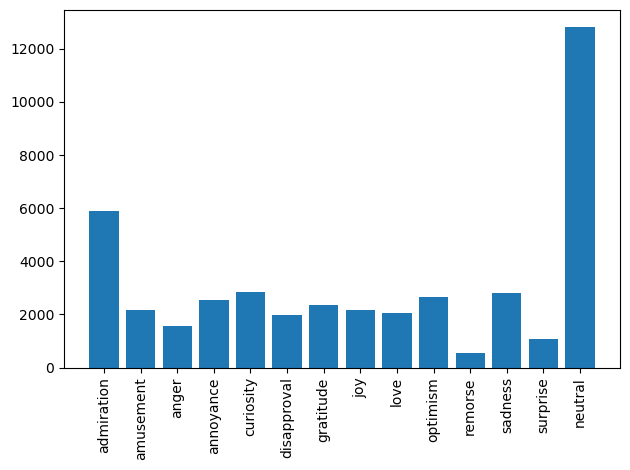

In [13]:
import matplotlib.pyplot as plt
from data.dataset import label_names, chosen_labels


def get_label_names():
    names = []

    for label in chosen_labels:
        names.append(label_names[label])
    names.append(label_names[27])

    return names

label_distribution = [0]*14

for label in train_dataset.y:
    label_distribution[label] += 1

plt.bar(get_label_names(), label_distribution)
plt.xticks(rotation=90)
plt.show()

# Evalutation Methods
## Confusion Matrix
A confusion matrix is used to visualise the performance of the classifier, this helps us see which labels the classifiers are making the most mistakes on.
The dataset is largely saturated by neutral tags, this means a raw confusion matrix turns out dark for all values apart from neural-neutral, to solve this my confusion matrix displays the log values.

In [14]:
import numpy as np
import seaborn as sb
import pandas as pd

from typing import Tuple, Optional

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def display_confusion_matrix(preds, y, scale="linear", save_name: Optional[Tuple[str, str]] = None):
    confusion_matrix = np.zeros((14,14)).astype(np.int32)

    for pred, label in zip(preds, y):
        confusion_matrix[pred, label] += 1

    if scale == "log":
        confusion_matrix = np.log2(confusion_matrix+1)
    
    chosen_label_names = get_label_names()
    heatmap_confusion_matrix = pd.DataFrame(confusion_matrix, index=chosen_label_names, columns=chosen_label_names)

    ax = plt.axes()
    sb.heatmap(heatmap_confusion_matrix, annot=True, ax=ax)
    scale_title = scale[0].upper() + scale[1:]
    ax.set_title(f"{scale_title} Confusion Matrix")

    if save_name != None:
        plt.savefig(f"./figures/{save_name[0]}/{save_name[1]}.png")

    plt.show()


## Precision, Recall, F1 Score
To keep track of the performance of each experiment on an induvidual label, by tracking how often a label is corrcetly guessed out of the the instances of that label and how ofter a guess of a label is correct out of all the guesses of that label.

In [15]:
from sklearn.metrics import precision_recall_fscore_support

def get_scores(labels, predictions, kernel_type = "linear", save_dir = "general"):
    prec, recall, f1, support = precision_recall_fscore_support(labels, predictions)

    results_dictionary = {"label":list(range(14)), "precision":prec, "recall":recall, "f1":f1}
    results = pd.DataFrame(results_dictionary)
    results.to_csv(f"figures/{save_dir}/{kernel_type}_kernel_metrics.csv", index=False)

    return results

## ROC Curve and AUC
The final evalutation metric looks at the relationship of the false positive and true positive rates, AUC calculates the area under the ROC curve.

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

def multiclass_roc_curve(predictions, labels, classes, experiment_dir, fig_name):
    labels = np.asarray(labels).flatten()
    chosen_label_names = get_label_names()
    for class_label in range(classes):
        not_class = labels != class_label
        is_class = labels == class_label

        class_labels = np.where(labels == class_label, 1, 0)
        class_predictions = predictions[:, class_label]

        fpr, tpr, _ = roc_curve(class_labels, class_predictions)
        auc = round(roc_auc_score(class_labels, class_predictions), 2)
        plt.plot(fpr,tpr,label=f"{chosen_label_names[class_label]} (AUC={auc})")
    
    plt.plot([0, 1], [0, 1], "k--", label="random performance")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Emotion Class vs Rest")
    plt.legend(loc="lower right", bbox_to_anchor=(1.6, 1.1),
          ncol=3, fancybox=True, shadow=True)
    plt.savefig(f"./figures/{experiment_dir}/{fig_name}.png")
    plt.show()

# Experiment 1: Different SVM kernel types
This experiment looks at the different kernel options used to build a support vector, the kernels covered are: linear, polynomial, radial basis function and sigmoid. This experiment is useful to see what kernel can create the best shaped hyperplane to correctly seperate the different classes. 
## Vectorisation using TFIDF 
The input text needs to be vectorised before it can be used for training a support vector machine. First stop words and non-alphabetic words are removed before being lemmatised. 

In [17]:
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download, pos_tag
download('punkt')
download('wordnet')
download('omw-1.4')
download('averaged_perceptron_tagger')
download('stopwords')

from collections import defaultdict

def lem_text(text, aslist=False):
    text = [word.lower() for word in text]
    text = [word_tokenize(word) for word in text]

    word_tags = defaultdict(lambda: wordnet.NOUN)
    word_tags['J'] = wordnet.ADJ
    word_tags['V'] = wordnet.VERB
    word_tags['R'] = wordnet.ADV

    for i, words in enumerate(text):
        lemmed_text = []
        lemmer = WordNetLemmatizer()

        for word, tag in pos_tag(words):
            if word not in stopwords.words('english') and word.isalpha():
                lem_word = lemmer.lemmatize(word, word_tags[tag[0]])
                lemmed_text.append(lem_word)

        if aslist:
            text[i] = lemmed_text
        else:
            text[i] = ' '.join(lemmed_text)

    return text

def drop_empty(dataset):
    new_x = []
    new_y = []
    for i in range(len(dataset)):
        if len(dataset.x[i]) > 0:
            new_x.append(dataset.x[i])
            new_y.append(dataset.y[i])
    dataset.x = new_x
    dataset.y = new_y

    return dataset

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
lem_example = lem_text(train_dataset.x[0:2])
print(lem_example[0])

favourite food anything cook


Once the text of all datasets has been lemmatised, the training data is used to extract the most important word tfidf features. These features are used to convert all dataset text entries into vectors.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_dataset_tfidf = EmotionsDataset(split="train")
test_dataset_tfidf = EmotionsDataset(split="test")

train_dataset_tfidf.x = lem_text(train_dataset_tfidf.x)
test_dataset_tfidf.x = lem_text(test_dataset_tfidf.x)

tfidf_vectoriser = TfidfVectorizer(max_features=500)
tfidf_vectoriser.fit(train_dataset_tfidf.x)

train_dataset_tfidf.x = tfidf_vectoriser.transform(train_dataset_tfidf.x)
test_dataset_tfidf.x = tfidf_vectoriser.transform(test_dataset_tfidf.x)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


In [19]:
print(train_dataset_tfidf.x[0])

  (0, 159)	0.7673799003128442
  (0, 24)	0.6411927078467511


## SVM kernel results
The performance of the SVM is evaluated with accuracy, recall, precision and f1 score

### Linear Kernel

In [9]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import os

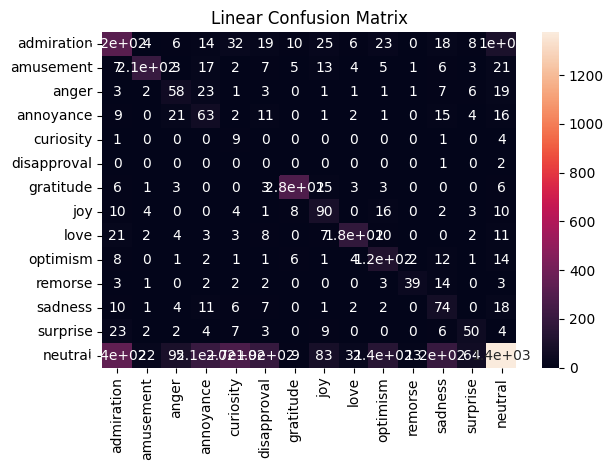

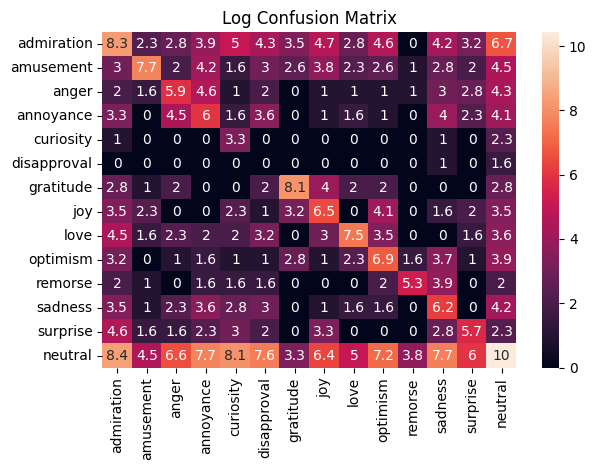

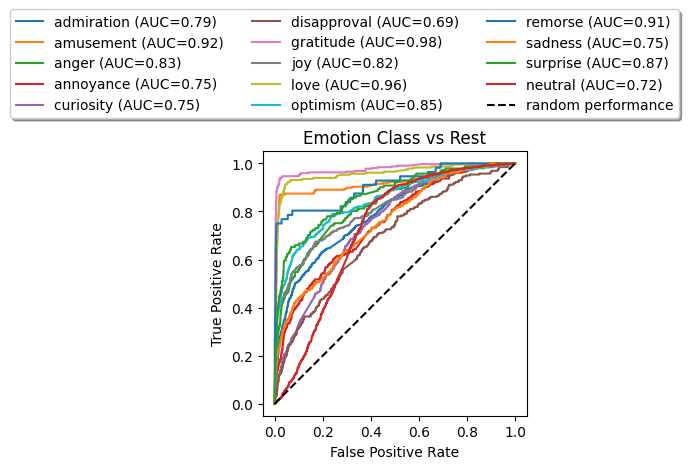

    label  precision    recall        f1
0       0   0.541237  0.417219  0.471204
1       1   0.688742  0.842105  0.757741
2       2   0.460317  0.294416  0.359133
3       3   0.434483  0.181034  0.255578
4       4   0.600000  0.026471  0.050704
5       5   0.000000  0.000000  0.000000
6       6   0.875776  0.881250  0.878505
7       7   0.608108  0.365854  0.456853
8       8   0.714859  0.767241  0.740125
9       9   0.684524  0.354938  0.467480
10     10   0.565217  0.696429  0.624000
11     11   0.544118  0.207865  0.300813
12     12   0.454545  0.354610  0.398406
13     13   0.450852  0.856787  0.590812
Testing Accuracy:  52.64418647503225


In [10]:
kernel_dir = "kernel_experiement"
if not os.path.exists(f"./figures/{kernel_dir}"):
    os.mkdir(f"./figures/{kernel_dir}")

svm_linear = svm.SVC(kernel='linear', probability=True)
svm_linear.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_linear.predict(test_dataset_tfidf.x)
preds_prob = svm_linear.predict_proba(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, save_name=(kernel_dir, "confusion_matrix_no_scaling"))
display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'linear_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="linear", save_dir=kernel_dir)
multiclass_roc_curve(preds_prob, test_dataset_tfidf.y, 14, kernel_dir, "linear_roc")
print(results)
print("Testing Accuracy: ", acc)

### Polynomial Kernel

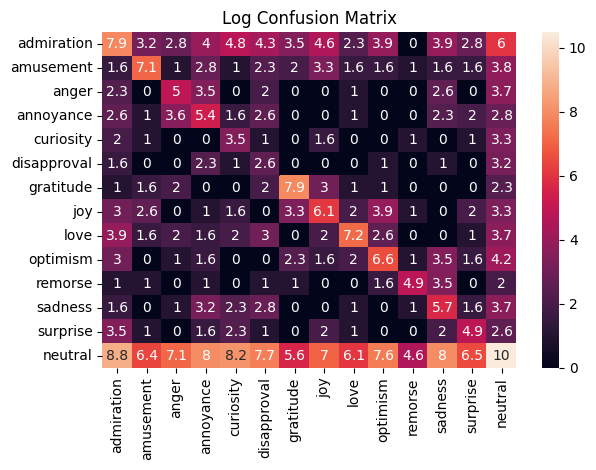

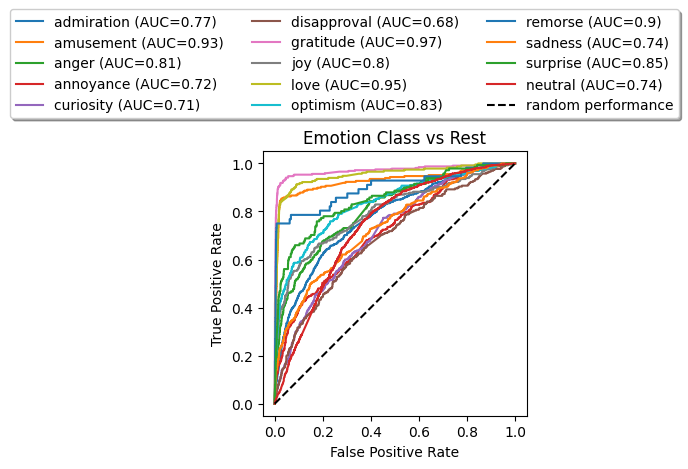

    label  precision    recall        f1
0       0   0.531250  0.315232  0.395677
1       1   0.746032  0.570850  0.646789
2       2   0.461538  0.152284  0.229008
3       3   0.518987  0.117816  0.192037
4       4   0.357143  0.029412  0.054348
5       5   0.227273  0.019305  0.035587
6       6   0.917603  0.765625  0.834753
7       7   0.560976  0.280488  0.373984
8       8   0.741294  0.642241  0.688222
9       9   0.659722  0.293210  0.405983
10     10   0.583333  0.500000  0.538462
11     11   0.584270  0.146067  0.233708
12     12   0.491525  0.205674  0.290000
13     13   0.390723  0.891656  0.543350
Testing Accuracy:  47.245255205454214


In [11]:
svm_poly = svm.SVC(kernel='poly', probability=True)
svm_poly.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_poly.predict(test_dataset_tfidf.x)
preds_prob = svm_poly.predict_proba(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'poly_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100
prec, recall, f1, support = precision_recall_fscore_support(test_dataset_tfidf.y, preds)

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="poly", save_dir=kernel_dir)
multiclass_roc_curve(preds_prob, test_dataset_tfidf.y, 14, kernel_dir, "poly_roc")

print(results)
print("Testing Accuracy: ", acc)

### Sigmoid Kernel

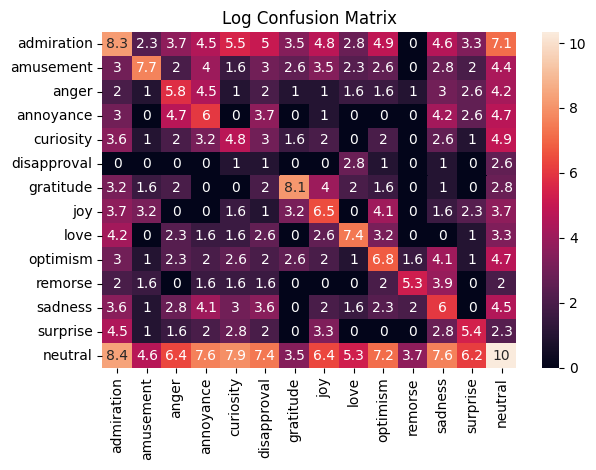

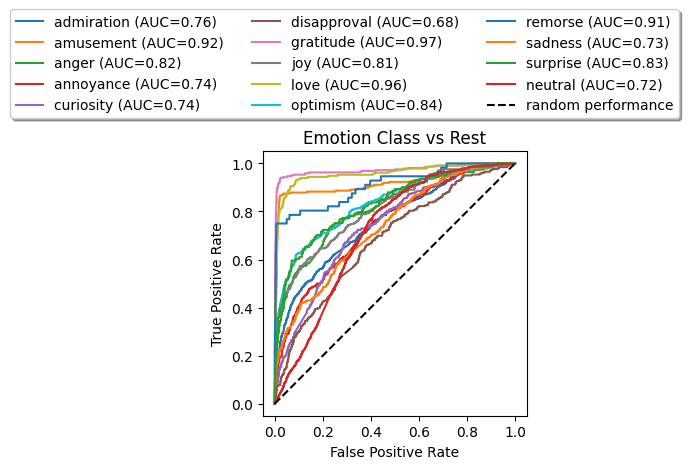

    label  precision    recall        f1
0       0   0.460725  0.403974  0.430487
1       1   0.698962  0.817814  0.753731
2       2   0.450000  0.274112  0.340694
3       3   0.410256  0.183908  0.253968
4       4   0.262626  0.076471  0.118451
5       5   0.066667  0.003861  0.007299
6       6   0.866460  0.871875  0.869159
7       7   0.575163  0.357724  0.441103
8       8   0.761261  0.728448  0.744493
9       9   0.589189  0.336420  0.428291
10     10   0.550725  0.678571  0.608000
11     11   0.430464  0.182584  0.256410
12     12   0.427083  0.290780  0.345992
13     13   0.445637  0.801370  0.572764
Testing Accuracy:  50.267182605491065


In [12]:
svm_sig = svm.SVC(kernel='sigmoid', probability=True)
svm_sig.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_sig.predict(test_dataset_tfidf.x)
preds_prob = svm_sig.predict_proba(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'sigmoid_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="sigmoid", save_dir=kernel_dir)
multiclass_roc_curve(preds_prob, test_dataset_tfidf.y, 14, kernel_dir, "sigmoid_roc")

print(results)
print("Testing Accuracy: ", acc)

### Radial Basis Function Kernel

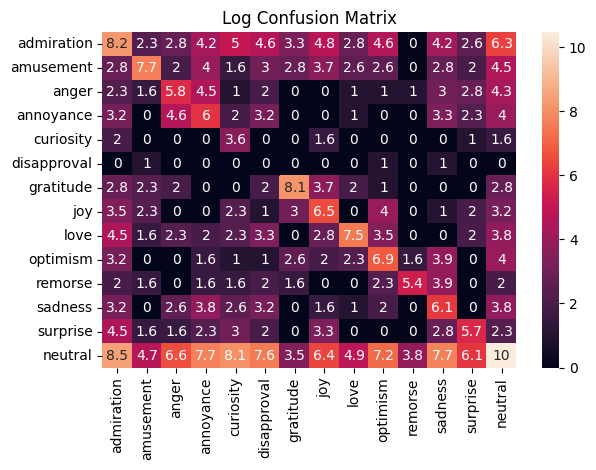

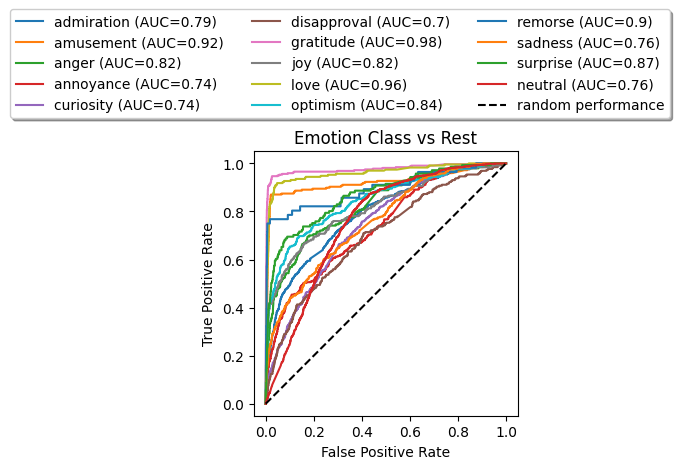

    label  precision    recall        f1
0       0   0.546279  0.398675  0.460949
1       1   0.686007  0.813765  0.744444
2       2   0.446281  0.274112  0.339623
3       3   0.462687  0.178161  0.257261
4       4   0.578947  0.032353  0.061281
5       5   0.000000  0.000000  0.000000
6       6   0.880878  0.878125  0.879499
7       7   0.634483  0.373984  0.470588
8       8   0.709302  0.788793  0.746939
9       9   0.676471  0.354938  0.465587
10     10   0.533333  0.714286  0.610687
11     11   0.546875  0.196629  0.289256
12     12   0.462963  0.354610  0.401606
13     13   0.453110  0.875467  0.597154
Testing Accuracy:  52.810023954302565


In [13]:
svm_rbf = svm.SVC(kernel='rbf', probability=True)
svm_rbf.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_rbf.predict(test_dataset_tfidf.x)
preds_prob = svm_rbf.predict_proba(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'rbf_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="rbf", save_dir=kernel_dir)

multiclass_roc_curve(preds_prob, test_dataset_tfidf.y, 14, kernel_dir, "rbf_roc")

print(results)
print("Testing Accuracy: ", acc)

# Experiment 2: SVM Hyper-parameter tuning
I will tune the hyper-parameters of SVM while keeping the kernel the same. I will use the radial basis function kernel as it has provided the best results in experiment 1. Searching for the an optimal set of hyperparameters can further increase accuracy as each dataset will work best with a different set of hyperparameters. 
## Grid Search
The hyper-parameters will be searched using a grid search technique. I will select a set of discrete values for each variable that I am changing. The variables I will focus on will be: the regularisation parameter, gamma value and stopping tolerance.

In [24]:
import time

c_values = [0.5, 1.0, 1.5, 2.0]
g_values = [0.5, 0.75, 1, 1.25, 1.5]
t_values = [1e-2, 1e-3, 1e-4]

grid_search_dir = 'grid_search_experiment'
if not os.path.exists(f"./figures/{grid_search_dir}"):
    os.mkdir(f"./figures/{grid_search_dir}")

c_tracking = []
g_tracking = []
t_tracking = []
accuracy_tracking = []
time_tracking = []

best_acc = 0.0
best_model = None

for c_value in c_values:
    for g_value in g_values:
        for t_value in t_values:
            test_name = f'{c_value}_{g_value}_{t_value}'

            svm_rbf = svm.SVC(kernel='rbf', C=c_value, gamma=g_value, tol=t_value, probability=True)

            start = time.time()
            svm_rbf.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
            end = time.time()

            preds = svm_rbf.predict(test_dataset_tfidf.x)

            acc = accuracy_score(test_dataset_tfidf.y, preds)*100

            if acc > best_acc:
                best_acc = acc
                best_model = svm_rbf

            results = get_scores(test_dataset_tfidf.y, preds, kernel_type=test_name, save_dir=grid_search_dir)
            
            print(f"Testing Accuracy ({test_name}): ", acc)
            print("Training Time: ", end-start)

            c_tracking.append(c_value)
            g_tracking.append(g_value)
            t_tracking.append(t_value)
            accuracy_tracking.append(acc)
            time_tracking.append(end-start)

grid_search_summary = pd.DataFrame({"Regularisation": c_tracking, "Gamma": g_tracking, "Tolerance": t_tracking, "Accuracy": accuracy_tracking, "Training Time": time_tracking})
grid_search_summary.to_csv(f'./figures/{grid_search_dir}/summary.csv')
            

Testing Accuracy (0.5_0.5_0.01):  52.3309379030772
Training Time:  502.60096621513367
Testing Accuracy (0.5_0.5_0.001):  52.3309379030772
Training Time:  586.2034449577332
Testing Accuracy (0.5_0.5_0.0001):  52.3309379030772
Training Time:  629.1401197910309
Testing Accuracy (0.5_0.75_0.01):  52.44149622259076
Training Time:  559.6834807395935
Testing Accuracy (0.5_0.75_0.001):  52.423069836005155
Training Time:  629.1526141166687
Testing Accuracy (0.5_0.75_0.0001):  52.423069836005155
Training Time:  660.399938583374
Testing Accuracy (0.5_1_0.01):  52.31251151649161
Training Time:  633.2279210090637
Testing Accuracy (0.5_1_0.001):  52.3309379030772
Training Time:  716.1941566467285
Testing Accuracy (0.5_1_0.0001):  52.3309379030772
Training Time:  751.308438539505
Testing Accuracy (0.5_1.25_0.01):  52.23880597014925
Training Time:  702.6288540363312
Testing Accuracy (0.5_1.25_0.001):  52.23880597014925
Training Time:  806.6785283088684
Testing Accuracy (0.5_1.25_0.0001):  52.238805970

In [15]:
import matplotlib.image as mpimg

In [34]:
results_summary = pd.read_csv(f'./figures/{grid_search_dir}/summary.csv')
best_summary = results_summary.query('Accuracy == Accuracy.max() & Tolerance == Tolerance.max()')
print(best_summary)

    Unnamed: 0  Regularisation  Gamma  Tolerance   Accuracy  Training Time
48          48             2.0   0.75       0.01  53.049567     650.137156


In [36]:
best_results = pd.read_csv(f'./figures/{grid_search_dir}/2_0.75_0.01_kernel_metrics.csv')
print(best_results)

    label  precision    recall        f1
0       0   0.542662  0.421192  0.474273
1       1   0.691525  0.825911  0.752768
2       2   0.441667  0.269036  0.334385
3       3   0.425806  0.189655  0.262425
4       4   0.351351  0.038235  0.068966
5       5   0.181818  0.007722  0.014815
6       6   0.889241  0.878125  0.883648
7       7   0.596154  0.378049  0.462687
8       8   0.699620  0.793103  0.743434
9       9   0.655367  0.358025  0.463074
10     10   0.558824  0.678571  0.612903
11     11   0.526667  0.221910  0.312253
12     12   0.467290  0.354610  0.403226
13     13   0.462827  0.860523  0.601916


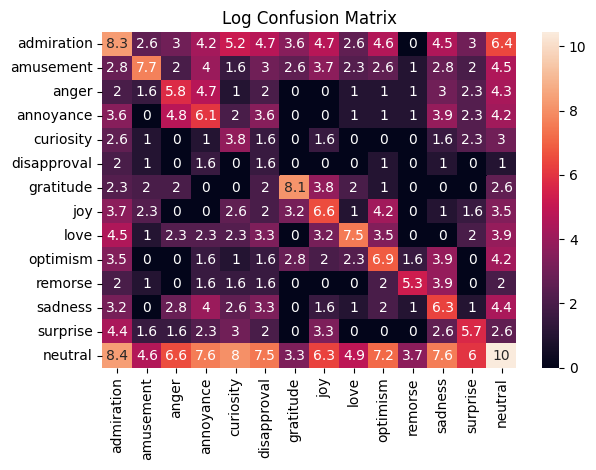

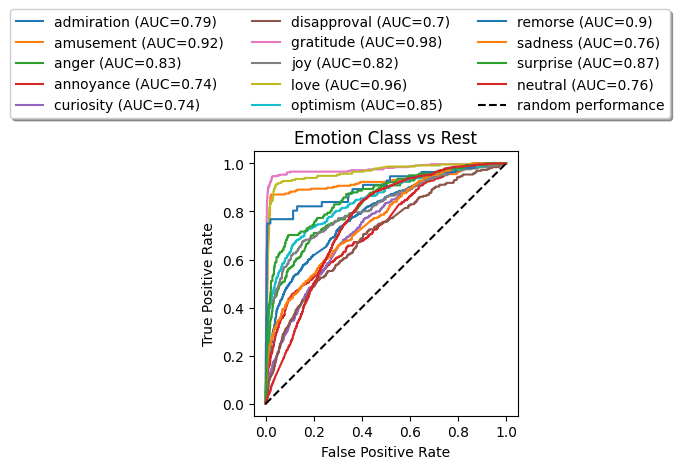

In [16]:
preds = best_model.predict(test_dataset_tfidf.x)
preds_prob = best_model.predict_proba(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(grid_search_dir, 'best_model_matrix'))
multiclass_roc_curve(preds_prob, test_dataset_tfidf.y, 14, grid_search_dir, "best_model")

# Experiment 3: The effect of using bag of words as data preprocessing
In the prior experiments tfidf is used to vectorise the text entries, this experiment looks at how using bags of words to vectorise data can effect the performance of SVM for classification. While bag of words removes a lot more context of the sentence, it is good to look at as it may be easier to fit for a simpler algorithm like SVM.
## Datset preprocessing 
First the text needs to be vectorised into a bag of words, to do this the CountVecotriser is used. I've chosen to extract the 1000 most common words to build the bags (not setting a maximum size would create a bag equal to the amount of unqiue words, which would create large vectors and greatly increase processing time)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

train_dataset_bags = EmotionsDataset(split="train")
test_dataset_bags = EmotionsDataset(split="test")

train_dataset_bags.x = lem_text(train_dataset_bags.x)
test_dataset_bags.x = lem_text(test_dataset_bags.x)

bag_vectoriser = CountVectorizer(max_features=500)
bag_vectoriser.fit(train_dataset_bags.x)

train_dataset_bags.x = bag_vectoriser.transform(train_dataset_bags.x)
test_dataset_bags.x = bag_vectoriser.transform(test_dataset_bags.x)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


## Training and evaluation


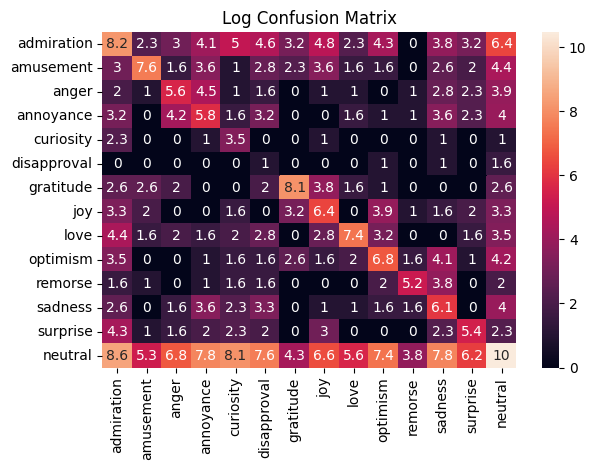

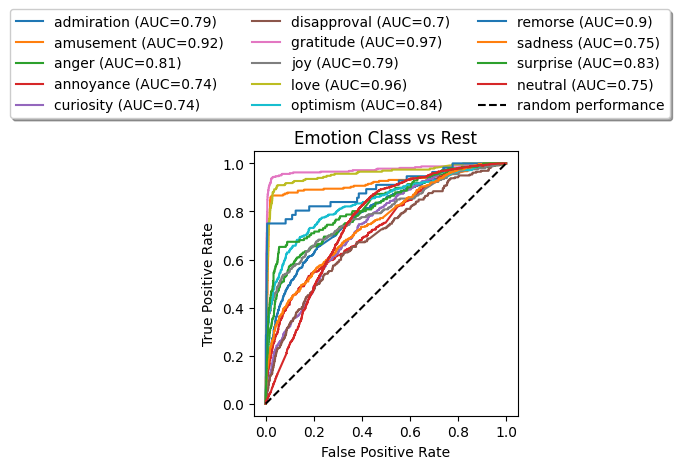

    label  precision    recall        f1
0       0   0.544256  0.382781  0.449456
1       1   0.721805  0.777328  0.748538
2       2   0.466019  0.243655  0.320000
3       3   0.444444  0.160920  0.236287
4       4   0.555556  0.029412  0.055866
5       5   0.200000  0.003861  0.007576
6       6   0.881789  0.862500  0.872038
7       7   0.622222  0.341463  0.440945
8       8   0.731602  0.728448  0.730022
9       9   0.643275  0.339506  0.444444
10     10   0.571429  0.642857  0.605042
11     11   0.563025  0.188202  0.282105
12     12   0.471910  0.297872  0.365217
13     13   0.432607  0.877335  0.579478
Testing Accuracy:  51.391192187212084


In [18]:
bag_dir = 'bag_of_words_experiment'
if not os.path.exists(f"./figures/{bag_dir}"):
    os.mkdir(f"./figures/{bag_dir}")

svm_bag = svm.SVC(kernel='rbf', probability=True)
svm_bag.fit(train_dataset_bags.x, train_dataset_bags.y)
preds = svm_bag.predict(test_dataset_bags.x)
preds_prob = svm_bag.predict_proba(test_dataset_bags.x)

display_confusion_matrix(preds, test_dataset_bags.y, scale="log", save_name=(bag_dir, 'bag_matrix'))

acc = accuracy_score(test_dataset_bags.y, preds)*100

results = get_scores(test_dataset_bags.y, preds, kernel_type="bag", save_dir=bag_dir)
multiclass_roc_curve(preds_prob, test_dataset_bags.y, 14, bag_dir, "bags_roc")

print(results)
print("Testing Accuracy: ", acc)

# Experiment 4: SVM training with word2vec vectors
Word2Vec is a system that encodes words as vectors by passing words through a 2 layer fully connected network with the label being the same, or a closely occuring word. This method naturally embeds words such that similar words are closely clustered. I will be using the skip gram approach which try to train a neural network to predict another word that is closely related to the words context. Word2Vec is being looked at as the last experiment as word embeddings can give greater meaning to each word in a mathemtical context. More related words will be found closer together than less related words which may help a SVM to create better seperation for each emotion class. 
## Word2Vec
I will be using the word2vec library by gensim first with a embedded dimension of 32 and be training my embeddings on the entire training vocabulary for 100 epochs

In [19]:
train_dataset_w2v = EmotionsDataset(split="train")
test_dataset_w2v = EmotionsDataset(split="test")

train_dataset_w2v.x = lem_text(train_dataset_w2v.x, aslist=True)
test_dataset_w2v.x = lem_text(test_dataset_w2v.x, aslist=True)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


In [20]:
from gensim.models import  Word2Vec
embed_dim = 32
word2vec = Word2Vec(vector_size=embed_dim, window=5, min_count=1, sg=0)
word2vec.build_vocab(train_dataset_w2v.x)
word2vec.train(train_dataset_w2v.x, total_examples=word2vec.corpus_count, epochs=100)

(24942971, 27657700)

In [21]:
print(word2vec)
print(word2vec.corpus_count)
print(word2vec.wv.most_similar('food'))

Word2Vec<vocab=20248, vector_size=32, alpha=0.025>
43410
[('slower', 0.7383174896240234), ('drink', 0.6971313953399658), ('celery', 0.687771201133728), ('fried', 0.6841360926628113), ('shelter', 0.6809514164924622), ('fasting', 0.6641553640365601), ('soda', 0.6503635048866272), ('soggy', 0.6318995356559753), ('milk', 0.6317488551139832), ('halal', 0.627301812171936)]


### Finding the correct vector length

As each sentence contains a different amount of words, I need to constrain how many words can be in each text entry. In the case where an entry has too many words the last few words will be dropped and where a text entry does not have enough words I will zero pad the remaining vectors. To figure out what a good length is for the sentences, I am going to analyse the minimum, maximum, mean and starndard deviation lengths. 

In [22]:
lengths = np.empty((len(train_dataset_w2v.x)))

for i, text in enumerate(train_dataset_w2v.x):
    lengths[i] = len(text)

print("Longest Sentence: ", lengths.max())
print("Shortest Sentence: ", lengths.min())
print("Average Sentence: ", lengths.mean())
print("Std: ", lengths.std())

Longest Sentence:  25.0
Shortest Sentence:  0.0
Average Sentence:  6.371273900023036
Std:  3.4131916755826888


This class can take any text entry and convert it to a vector of constant pre-determinded length. Cases where a word does not exist in the word2vec vocabulary will place a null vector where the word would otherwise be.

In [23]:
from typing import List
class SentenceVectoriser():
    def __init__(self, word2vec, target_len: int, embed_dim: int):
        self.w2v = word2vec
        self.target_len = target_len
        self.embed_dim = embed_dim

    def vectorise(self, sentence: List[str]):
        vectors = np.zeros((self.target_len, self.embed_dim))

        word_index = 0
        while(word_index < len(sentence) and word_index < self.target_len):
            try:
                vector = self.w2v[sentence[word_index]]
                vectors[word_index] = vector
            except:
                print(f"Word: {sentence[word_index]}, is not supported by word2vec model")

            word_index += 1

        return vectors.flatten()
    
def vectorise_dataset(dataset, sentence_vectoriser: SentenceVectoriser):
    for i, text in enumerate(dataset):
        dataset[i] = sentence_vectoriser.vectorise(text)

    return dataset

Using the sentence length analysis I have chosen to target a sentence length of 13 words. As the mean length is around 6 and the standard deviation is around 3, a length of 13 will allow me to capture the full context for roughly 95% of the dataset, longer sentences will lose data. As each sentence will contain 13 words, each with a dimension of 32, the final vector size of a text entry will be 13*32 = 416

In [24]:
w2v_vectoriser = SentenceVectoriser(word2vec.wv, target_len=13, embed_dim=embed_dim)

train_dataset_w2v.x = vectorise_dataset(train_dataset_w2v.x, w2v_vectoriser)
test_dataset_w2v.x = vectorise_dataset(test_dataset_w2v.x, w2v_vectoriser)

Word: sapphira, is not supported by word2vec model
Word: cirilla, is not supported by word2vec model
...
Word: elmo, is not supported by word2vec model
Word: grouchland, is not supported by word2vec model
Word: elmo, is not supported by word2vec model


In [25]:
print(train_dataset_w2v.x[0])
print(test_dataset_w2v.x[0])

[ 0.21074483  0.75110459 -2.71859241 -1.98448312  0.83124644 -0.75992829
  0.81962335  0.79121768 -1.8838079   1.95201266  3.02937603 -1.21269941
 -2.64481211 -0.1254262   0.03374527 -3.30113316 -4.24235821  0.4697338
 -1.84145093  1.8139106   2.62679243  0.5091486   0.23420663  3.77702403
  0.74193209 -1.28686988  1.18493819  2.07036376  4.41175508 -0.92256558
  0.36913067 -0.95298737  1.6751467   0.42989719  0.56979549 -2.46846461
  2.11959338 -3.64203048  2.13089752 -0.43203208 -1.80949938 -2.58256721
  0.56096202 -2.03536129 -1.57216358 -5.57925367  1.50494146  5.29707336
...
[ 2.58287477 -0.09718723  1.68640876  2.00682092 -0.22046889 -1.35842299
 -0.28502718  0.53833002 -1.06242037 -0.10124002 -0.18191294 -0.17009544
 -0.09398551  0.96867853 -0.45246571 -0.6951946   0.71630037 -0.8811667
 -0.6862278   0.3962236  -2.40278292  0.22644834  0.26305458  0.14714256
  0.17199011  1.31946635  0.89692122  0.14614393  0.49559733 -2.02363682
 -0.0905228  -0.07315183  1.01954651 -1.27084446 

In [26]:
svm_w2v = svm.SVC(kernel='rbf', probability=True)
svm_w2v.fit(train_dataset_w2v.x, train_dataset_w2v.y)

SVC(probability=True)

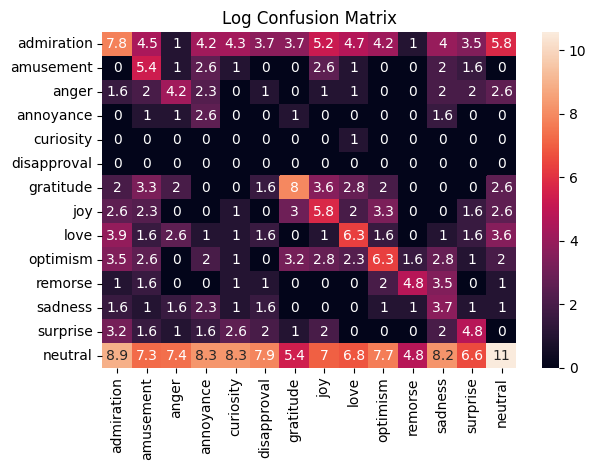

c:\Users\ryans\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


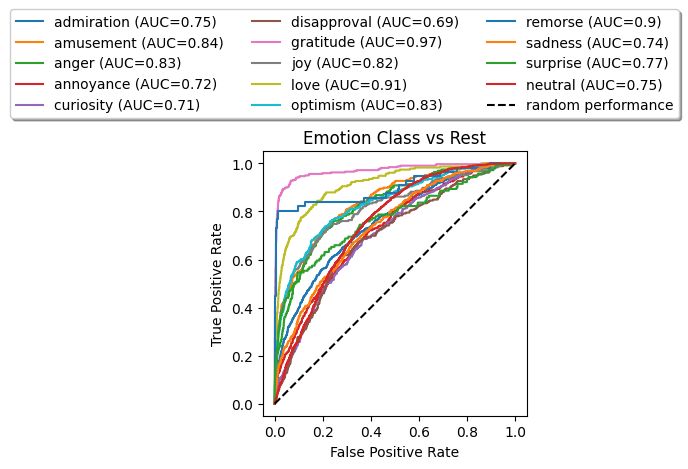

    label  precision    recall        f1
0       0   0.476190  0.291391  0.361545
1       1   0.689655  0.161943  0.262295
2       2   0.439024  0.091371  0.151261
3       3   0.500000  0.014368  0.027933
4       4   0.000000  0.000000  0.000000
5       5   0.000000  0.000000  0.000000
6       6   0.855670  0.778125  0.815057
7       7   0.595506  0.215447  0.316418
8       8   0.655738  0.344828  0.451977
9       9   0.617188  0.243827  0.349558
10     10   0.577778  0.464286  0.514851
11     11   0.428571  0.033708  0.062500
12     12   0.481481  0.184397  0.266667
13     13   0.371157  0.947073  0.533310
Testing Accuracy:  42.915054357840425


In [27]:
w2v_dir = "word2vec_experiment"
if not os.path.exists(f"./figures/{w2v_dir}"):
    os.mkdir(f"./figures/{w2v_dir}")

preds = svm_w2v.predict(test_dataset_w2v.x)
preds_prob = svm_w2v.predict_proba(test_dataset_w2v.x)

display_confusion_matrix(preds, test_dataset_w2v.y, scale="log", save_name=(w2v_dir, 'w2v_matrix'))

acc = accuracy_score(test_dataset_w2v.y, preds)*100

results = get_scores(test_dataset_w2v.y, preds, kernel_type="w2v", save_dir=w2v_dir)
multiclass_roc_curve(preds_prob, test_dataset_w2v.y, 14, w2v_dir, "w2v_roc")

print(results)
print("Testing Accuracy: ", acc)

### word2vec using a pretrained FastText model
The poor performance of the previous word2vec model may be due to a lack of training data to build good word embeddings, furhtermore some words were present in the test dataset which were not in the training dataset, therefore they could not be correctly embedded. My final approach will look at using a pretrained word2vec model made by facebook which has been trained on a much larger vocabulary and with much more sentence examples, therefore creating stronger embeddings. 

In [28]:
train_dataset_ft = EmotionsDataset(split="train")
test_dataset_ft = EmotionsDataset(split="test")

train_dataset_ft.x = lem_text(train_dataset_ft.x, aslist=True)
test_dataset_ft.x = lem_text(test_dataset_ft.x, aslist=True)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


In [2]:
from gensim.models import  FastText
from gensim.models import  fasttext as fasttext_gensim
import fasttext
import fasttext.util
from data.dataset import download_model

embed_dim = 32

download_model()
fastvec = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(fastvec, embed_dim)
fastvec.save_model(f'cc.en.{embed_dim}.bin')

In [ ]:
fastvec = fasttext.load_model(f'cc.en.{embed_dim}.bin')

In [ ]:
print(fastvec)
print(fastvec.get_nearest_neighbors('food'))

[(0.8604048490524292, 'food-'), (0.8406769633293152, 'cooking'), (0.8322345018386841, 'foods'), (0.8280719518661499, 'vegetables'), (0.820582926273346, 'seafood'), (0.8153938055038452, 'edibles'), (0.8134177923202515, 'food.For'), (0.8052072525024414, 'coffee'), (0.8012819290161133, 'food.Here'), (0.8007567524909973, 'meals')]


In [32]:
fast_vectoriser = SentenceVectoriser(fastvec, target_len=13, embed_dim=embed_dim)

train_dataset_ft.x = vectorise_dataset(train_dataset_ft.x, fast_vectoriser)
test_dataset_ft.x = vectorise_dataset(test_dataset_ft.x, fast_vectoriser)

In [33]:
print(train_dataset_ft.x[0][:embed_dim])
print(test_dataset_ft.x[0][:embed_dim])

[ 0.03914886 -0.00987839 -0.04386057 -0.10737398  0.01306652 -0.05530238
  0.08500936 -0.02323711 -0.1158141  -0.08978817 -0.03398959 -0.02809607
 -0.0099913  -0.05916391  0.04672972 -0.00902327  0.17644025  0.03551088
  0.00588973  0.00089646  0.0358346   0.0497804   0.00423134 -0.02903047
  0.00379515 -0.01505077  0.06045171  0.02747935  0.01421329  0.04706496
  0.01390164 -0.02416636]
[ 0.09021883 -0.10378112 -0.02735664 -0.11800977  0.12851459  0.02634445
 -0.05310991  0.02258352 -0.08463824 -0.01103994 -0.01371828  0.00859732
  0.03705555 -0.01568737 -0.01236792  0.11266836  0.06790145  0.00841006
  0.01385703  0.00551916  0.06554019 -0.00607372  0.02124221  0.00581417
  0.03793361  0.02986311 -0.01718938  0.00305551 -0.07500389 -0.02348224
  0.04794927 -0.03567544]


In [34]:
svm_ft = svm.SVC(kernel='rbf', probability=True, tol=1e-2)
svm_ft.fit(train_dataset_ft.x, train_dataset_ft.y) 

SVC(probability=True, tol=0.01)

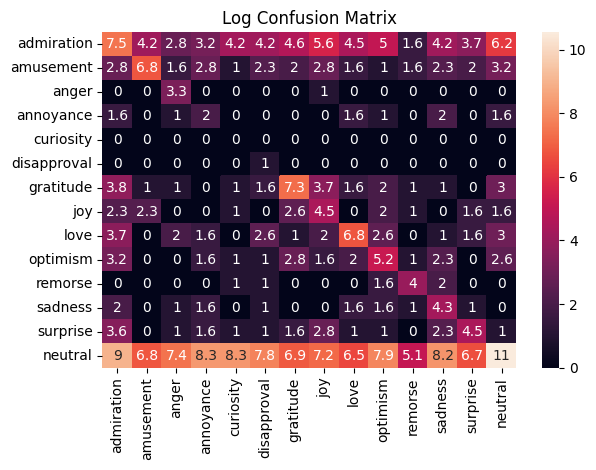

c:\Users\ryans\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


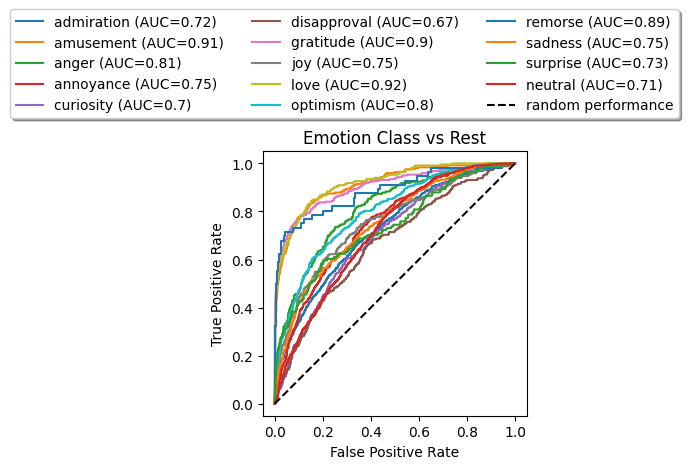

    label  precision    recall        f1
0       0   0.376596  0.234437  0.288980
1       1   0.700000  0.453441  0.550369
2       2   0.900000  0.045685  0.086957
3       3   0.214286  0.008621  0.016575
4       4   0.000000  0.000000  0.000000
5       5   1.000000  0.003861  0.007692
6       6   0.784314  0.500000  0.610687
7       7   0.488372  0.085366  0.145329
8       8   0.726667  0.469828  0.570681
9       9   0.521739  0.111111  0.183206
10     10   0.681818  0.267857  0.384615
11     11   0.593750  0.053371  0.097938
12     12   0.403846  0.148936  0.217617
13     13   0.357619  0.935243  0.517396
Testing Accuracy:  40.26165468951539


In [35]:
preds = svm_ft.predict(test_dataset_ft.x)

display_confusion_matrix(preds, test_dataset_ft.y, scale="log", save_name=(w2v_dir, 'fasttext_matrix'))

acc = accuracy_score(test_dataset_ft.y, preds)*100

results = get_scores(test_dataset_ft.y, preds, kernel_type="fasttext", save_dir=w2v_dir)

prob_preds = svm_ft.predict_proba(test_dataset_ft.x)
multiclass_roc_curve(prob_preds, test_dataset_ft.y, 14, w2v_dir, "fasttext_roc")

print(results)
print("Testing Accuracy: ", acc)

In [36]:
print(prob_preds)

[[0.09696219 0.02386766 0.00939886 ... 0.05191995 0.01594977 0.05542753]
 [0.17409439 0.02543804 0.0214703  ... 0.15028358 0.03047959 0.24438616]
 [0.31289435 0.04584874 0.0215894  ... 0.04413702 0.02165033 0.08728234]
 ...
 [0.10994946 0.01410462 0.02602159 ... 0.06345081 0.01623058 0.50967042]
 [0.02899528 0.02113296 0.00132283 ... 0.03592613 0.01277854 0.01881931]
 [0.19944252 0.2225008  0.02722541 ... 0.05233983 0.03661579 0.16255494]]
